# Exploratory data analysis

## 1. Dataset description


## 2. Load the dataset

In [117]:
import json

from functools import reduce
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import altair as alt
from collections import Counter

import os.path
import numpy as np
import re
import pandas as pd

import gensim 
from gensim.models import LdaModel
from gensim.models.wrappers import LdaMallet

import gensim.corpora as corpora
from gensim.corpora import Dictionary

from gensim import matutils, models

import pyLDAvis.gensim
import string
pd.set_option('display.max_colwidth', 100)
%matplotlib inline

In [2]:
set_names = ['rsicd', 'ucm', 'sydney']

def get_img_info(name):
    """
    Returns img paths and captions

    Parameters:
    -----------
    name: str
        the json file name
    
    Return:
    --------
    list, list
        img paths, corresponding captions
    """
    img_path = []
    caption = [] 
    caption_token = []
    with open('../data/interim/' + name + '.json', 'r') as json_data:
        data = json.load(json_data)
        for set_name in set_names:
            for filename in data[set_name].keys():
                img_path.append('../data/raw/imgs/'+ set_name + '/' + filename)
                caption.append([sentence['raw'] for sentence in data[set_name][filename]['sentences']])
                caption_token.append([sentence['tokens'] for sentence in data[set_name][filename]['sentences']])
    
    return img_path, caption, caption_token

In [3]:
# get img path and caption list
train_img_path, train_caption, train_caption_token = get_img_info('train')
valid_img_path, valid_caption, valid_caption_token = get_img_info('valid')

In [4]:
train_img_path[:10]

['../data/raw/imgs/rsicd/church_212.jpg',
 '../data/raw/imgs/rsicd/church_145.jpg',
 '../data/raw/imgs/rsicd/farmland_12.jpg',
 '../data/raw/imgs/rsicd/beach_161.jpg',
 '../data/raw/imgs/rsicd/sparseresidential_227.jpg',
 '../data/raw/imgs/rsicd/pond_60.jpg',
 '../data/raw/imgs/rsicd/denseresidential_31.jpg',
 '../data/raw/imgs/rsicd/00072.jpg',
 '../data/raw/imgs/rsicd/industrial_202.jpg',
 '../data/raw/imgs/rsicd/bareland_43.jpg']

In [5]:
train_caption[:10]

[['some buildings and many green trees are around a gray church .',
  'some buildings and many green trees are around a gray church .',
  'some buildings and many green trees are around a gray church .',
  'some buildings and many green trees are around a gray church .',
  'some buildings and many green trees are around a gray church .'],
 ['a church is near a river with some buildings and green trees .',
  'a church is near a river with some buildings and green trees .',
  'a church is near a river with some buildings and green trees .',
  'a church is near a river with some buildings and green trees .',
  'a church is near a river with some buildings and green trees .'],
 ['several pieces of farmland s are together .',
  'the textures in the farmland are very beautiful .',
  'the textures in the farmland are very beautiful .',
  'several pieces of farmland s are together .',
  'several pieces of farmland s are together .'],
 ['two rows of waves in green ocean are near a yellow beach 

## 3. Explore the dataset

### 1. find max/min length

In [103]:
max_len = 0
min_len = len(train_caption_token[0][0])

for t in train_caption_token:
    for i in t:
        if len(i) > max_len:
            max_len = len(i)
        if len(i) < min_len and len(i) > 1:
            min_len = len(i)
        if len(i) == 1:
            print("The caption with length as 1: ", i, "\n")
            
print("The maximum length of training set is", max_len, "\n")
print("The minimum length of training set is", min_len, "\n")

The caption with length as 1:  ['1'] 

The caption with length as 1:  ['1'] 

The maximum length of training set is 34 

The minimum length of training set is 2 



> Note: We found that there are 2 captions with only "1", which is meaningless, we will remove this kind of caption in data preprocssing stage.

### 2. find most common words

In [105]:
# 2. find most common words
# original version
flattened1 = [val for sublist in train_caption_token for val in sublist]
flattened = [val.lower() for sublist in flattened1 for val in sublist]

# without stopwords version
stopwords = set(STOPWORDS) 
flattened1_wo_stop = flattened1.copy()
flattened1_wo_stop[:] = [[word for word in sub if word not in stopwords] for sub in flattened1_wo_stop]
flattened_wo_stop = [word for word  in flattened if word not in stopwords]

In [107]:
c = Counter(item for item in flattened)
c_wo_stop = Counter(item for item in flattened_without_stop)
print(c.most_common(10))
print(c_wo_stop.most_common(10))

[('a', 37745), ('are', 21313), ('the', 17621), ('green', 16934), ('and', 15818), ('in', 15584), ('many', 15453), ('of', 14579), ('is', 13738), ('trees', 13451)]
[('green', 16934), ('many', 15453), ('trees', 13451), ('buildings', 11264), ('near', 7363), ('area', 5921), ('two', 5428), ('several', 4552), ('river', 4131), ('piece', 4100)]


In [108]:
# wordcloud
comment_words= ""
comment_words += " ".join(flattened)

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                collocations = False).generate_from_frequencies(c) 


comment_words_wo_stopwords = ""
comment_words_wo_stopwords += " ".join(flattened_without_stop)

wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                collocations = False).generate_from_frequencies(c_wo_stop) 

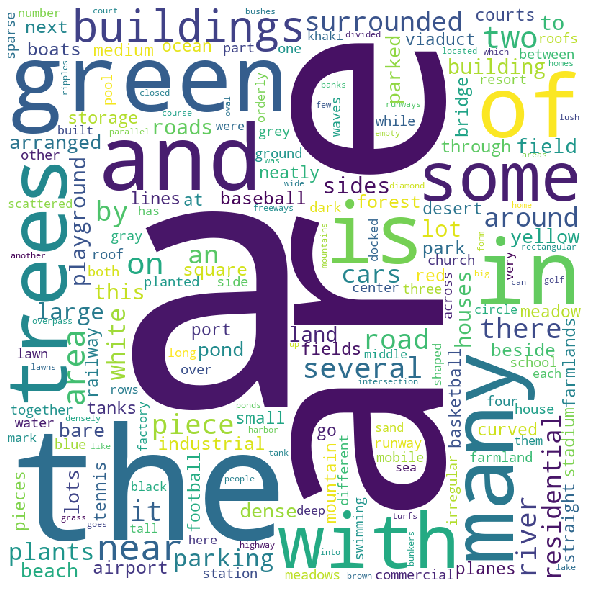

In [109]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

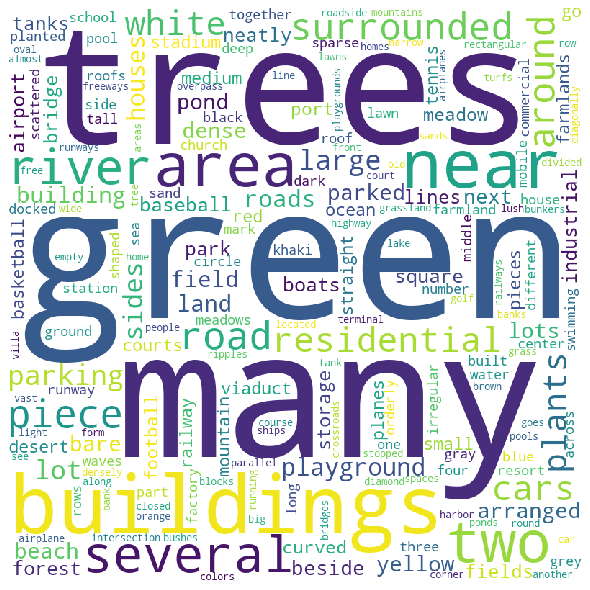

In [110]:
# plot the WordCloud image for non-stopwords version                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### 3. topic modelling



In [81]:
# create a dictionary
dictionary = corpora.Dictionary(flattened1_wo_stop)

# create document-term co-occurrence matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in flattened1_wo_stop]

In [88]:
# lda model configuration
lda = models.LdaModel(corpus=doc_term_matrix, 
                      id2word=dictionary, 
                      num_topics=5, 
                      passes=10)

In [113]:
lda.print_topics(num_words=4)

[(0, '0.085*"cars" + 0.059*"parking" + 0.050*"lot" + 0.044*"parked"'),
 (1, '0.146*"area" + 0.088*"arranged" + 0.083*"residential" + 0.076*"many"'),
 (2, '0.102*"river" + 0.077*"piece" + 0.076*"green" + 0.040*"beach"'),
 (3, '0.116*"green" + 0.097*"trees" + 0.052*"many" + 0.051*"buildings"'),
 (4, '0.073*"A" + 0.055*"roads" + 0.043*"houses" + 0.041*"There"')]

In [86]:
import warnings
warnings.filterwarnings('ignore')

In [114]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.230299  0.264969       1        1  16.233032
1     -0.140465 -0.195550       2        1  19.405210
2     -0.187895  0.128264       3        1  15.387753
3     -0.186188  0.017428       4        1  30.977354
4      0.284249 -0.215111       5        1  17.996655, topic_info=             Term          Freq         Total Category  logprob  loglift
39           area   7701.000000   7701.000000  Default  30.0000  30.0000
8           river   4275.000000   4275.000000  Default  29.0000  29.0000
114      arranged   4663.000000   4663.000000  Default  28.0000  28.0000
41    residential   4372.000000   4372.000000  Default  27.0000  27.0000
4           green  14929.000000  14929.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
74           road    984.857788   2983.957520   Topic5  -3.9064   0.6065
92          white    987.131042   3824.337891   Topic5  -3.9041   0.3606
2135           An    623.497375   1265.014893   Topic5  -4.3636   1.0075
2137         Many    602.974731   1735.133545   Topic5  -4.3970   0.6580
65         ground    489.616272    701.335938   Topic5  -4.6053   1.3556

[241 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2122      5  0.999620         A
2135      1  0.506713        An
2135      5  0.492484        An
2151      3  0.997784     Green
2121      5  0.998924        It
...     ...       ...       ...
92        3  0.430663     white
92        4  0.075569     white
92        5  0.258084     white
388       2  0.996538  withered
21        3  0.999323    yellow

[234 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

### 4. Check images with 5 duplicate captions

In [152]:
# check the length of captions
count_duplicate_captions = 0
for l in train_caption:
    if l.count(l[0]) == len(l):
        count_duplicate_captions += 1
print("Number of images with 5 duplicate captions:", count_duplicate_captions)
print("Ratio of images with 5 duplicate captions:", count_duplicate_captions/len(train_caption))

Number of images with 5 duplicate captions: 3162
Ratio of images with 5 duplicate captions: 0.36240687679083095


In [181]:
# check the length of captions
count_duplicate_captions = []
for l in train_caption:
    c = Counter(l)
    count_duplicate_captions.append(len(c.items()))

df_cap = pd.DataFrame(Counter(count_duplicate_captions).items(),
            columns = ['number of unique captions per image', 'number of images'])
alt.Chart(df_cap, title = "Number of unique captions").mark_bar().encode(
    alt.Y("number of unique captions per image:O"),
    alt.X("number of images:Q"),
)

alt.Chart(...)

## 4. Initial thoughts


## 5. Wrangling

> Discussion required: how to deal with "1"

## 6. Research questions



## 7. Data Analysis & Visualizations

In [115]:
# distribution of top 50 words
top_50_wo_stop = pd.DataFrame(c_wo_stop.most_common(50), columns = ['word', 'frequency']).sort_values(by = 'frequency').reset_index()

In [118]:
alt.Chart(top_50_wo_stop, title = "Top 50 words").mark_bar().encode(
    alt.X("word:N", sort='-y'),
    alt.Y("frequency:Q"),
)

alt.Chart(...)

In [131]:
# distribution of top 50 least common words
least_50_wo_stop = pd.DataFrame(c_wo_stop.most_common()[:-51:-1], columns = ['word', 'frequency']).sort_values(by = 'frequency').reset_index()

In [134]:
alt.Chart(least_50_wo_stop, title = "Top 50 least common words").mark_bar().encode(
    alt.X("word:N", sort='-y'),
    alt.Y("frequency:Q"),
)

alt.Chart(...)

## 8. Summary and conclusions
